# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\babarohitk\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

### Balancing the Dataset

In [15]:
# Choosing positive and negative reviews
df_pos=final[final.Score == 1]
df_neg=final[final.Score == 0]

# Reducing reviews to 50k each from each class
df_pos = df_pos.sample(n=50000, random_state=0)
df_neg = df_neg.sample(n=50000, random_state=0)

# Shuffling dataset
final = pd.concat([df_pos,df_neg], ignore_index=True)
final['Score'].value_counts()

1    50000
0    50000
Name: Score, dtype: int64

In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,391178,B001M23YBW,A3K2C0JEI6P271,R. Brown,1,1,1,1278374400,My sister likes it. I don't.,If you want a conversation item for a gatherin...
1,514354,B002MZVVZ4,A3F7NO1Q3RQ9Y0,Juiblex,1,1,1,1311811200,Nuance . . .,"First off, do yourself a favor and buy the mos..."
2,261099,B0012KB47K,AERQR8MGKFSD4,joleco,1,1,1,1232496000,Kitty Goodies,I haven't seen this in the store. All my cats...
3,74297,B000LLKCBK,A26OPNLJ0JYHPH,Irish Lace,1,1,1,1342915200,This is what you need for a great taco. Trust ...,"For years ... and I am not kidding, literally ..."
4,362211,B001AWBZQK,A2QWINO7M97YOL,Judith Bird,1,1,1,1312934400,Good but not outstanding,This tuna-based wet food is liked by two picky...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
final['Text'].values[0]+=" "+final['Summary'].values[0]
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much. My sister likes it. I don't.
First off, do yourself a favor and buy the most lean bacon you can find. Not because it's healthier, because it taste better, there's more substance, etc. . .<br /><br />Okay about the genie. It simply wont catch all the grease that comes off of the bacon. Some with burst from it and you will end up having to clean your microwave. It's not a bad as just microwaving

In [18]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,391178,B001M23YBW,A3K2C0JEI6P271,R. Brown,1,1,1,1278374400,My sister likes it. I don't.,If you want a conversation item for a gatherin...
1,514354,B002MZVVZ4,A3F7NO1Q3RQ9Y0,Juiblex,1,1,1,1311811200,Nuance . . .,"First off, do yourself a favor and buy the mos..."
2,261099,B0012KB47K,AERQR8MGKFSD4,joleco,1,1,1,1232496000,Kitty Goodies,I haven't seen this in the store. All my cats...
3,74297,B000LLKCBK,A26OPNLJ0JYHPH,Irish Lace,1,1,1,1342915200,This is what you need for a great taco. Trust ...,"For years ... and I am not kidding, literally ..."
4,362211,B001AWBZQK,A2QWINO7M97YOL,Judith Bird,1,1,1,1312934400,Good but not outstanding,This tuna-based wet food is liked by two picky...


In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)
print(sent_0)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much. My sister likes it. I don't.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it 4 starts because others I know do like it very much. My sister likes it. I don't.
First off, do yourself a favor and buy the most lean bacon you can find. Not because it's healthier, because it taste better, there's more substance, etc. . .Okay about the genie. It simply wont catch all the grease that comes off of the bacon. Some with burst from it and you will end up having to clean your microwave. It's not a bad as just microwaving it on a plate, but stil

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    #To remove repetetive words like aa bbb ccc
    phrase = re.sub(r"(.)\1{2,}","", phrase)
    #To remove 1 and 2 letter words
    phrase = re.sub(r"\W*\b\w{1,2}\b","", phrase)
    
    return phrase

In [22]:
sent_1500 = "was way to hot for my blood, took a bite and did a jig aaa lol zzzzzz a ab ok om sj"
print(sent_1500)
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig aaa lol zzzzzz a ab ok om sj
was way hot for blood, took bite and did jig  lol


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

If you want a conversation item for a gathering then popcorn cobs may suffice. Everyone seems to find it interesting and fun but when it is time to eat the popcorn people have different taste and not everyone seems to like this popcorn. My sister likes it a lot, but then she likes hot air popcorn. While the flavor is good the popcorn is too dry for my enjoyment.<br /><br />Bottom line: This is a conversation starter with very good corn taste, but if you don't like hot air popcorn then you may not like this. Even though I don't like it I give it  starts because others I know do like it very much. My sister likes it. I don't.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way hot for blood took bite and did jig lol


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:56<00:00, 1757.41it/s]


In [27]:
preprocessed_reviews[1500]

'ordered early year find use sorts dishes much interesting brown white rice combination produces great flavor great texture buying use current order update may ordered rice excellent variety dishes priced nicely least compared alternatives local grocery store favorite recipe cook added bouillion real chicken stock add tsp butter add dry chopped onion sage basil oregano whatever else feel like cook normal minutes'

# Feature Engineering

In [33]:
#Adding Column Length(of review)
Review_length=[]
for i in range(len(final)):
    #x=str(len(final['Text'].values[i]))
    x=len(preprocessed_reviews[i])
    Review_length.append(x)
final['Length']=Review_length
Review_length[1500]

414

In [34]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Length
0,391178,B001M23YBW,A3K2C0JEI6P271,R. Brown,1,1,1,1278374400,My sister likes it. I don't.,If you want a conversation item for a gatherin...,397
1,514354,B002MZVVZ4,A3F7NO1Q3RQ9Y0,Juiblex,1,1,1,1311811200,Nuance . . .,"First off, do yourself a favor and buy the mos...",392
2,261099,B0012KB47K,AERQR8MGKFSD4,joleco,1,1,1,1232496000,Kitty Goodies,I haven't seen this in the store. All my cats...,42
3,74297,B000LLKCBK,A26OPNLJ0JYHPH,Irish Lace,1,1,1,1342915200,This is what you need for a great taco. Trust ...,"For years ... and I am not kidding, literally ...",1114
4,362211,B001AWBZQK,A2QWINO7M97YOL,Judith Bird,1,1,1,1312934400,Good but not outstanding,This tuna-based wet food is liked by two picky...,188


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaah', 'aachen', 'aad', 'aafco', 'aafcoa', 'aah', 'aamazon', 'aamzon', 'aand', 'aap']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 69462)
the number of unique words  69462


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 57984)
the number of unique words including both unigrams and bigrams  57984


# [5] Assignment 4: Apply Naive Bayes

 <ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [35]:
# Please write all the code with proper documentation
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB

In [64]:
X=preprocessed_reviews
X=np.array(X)
Y = np.array(final['Score'])

#Spliting Dataset to (Train-CrossValidation)70%,(Test)30%
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X, Y, test_size=0.3,random_state=0,stratify = Y)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_cv, Y_cv, test_size=0.3,random_state=0,stratify = Y_cv)

In [65]:
unique_elements, counts_elements = np.unique(Y_tr, return_counts=True)
print("Value counts of class labels in Train data set:")
print(np.asarray((unique_elements, counts_elements)))

Value counts of class labels in Train data set:
[[    0     1]
 [35000 35000]]


In [66]:
#Text to Bag of words(Vectors)
count_vect = CountVectorizer()
final_X_tr=count_vect.fit_transform(X_tr)
final_X_test=count_vect.transform(X_test)
final_X_cv=count_vect.transform(X_cv)

In [76]:
Y_tr.shape

(70000,)

In [77]:
# Fuction to compute best Alpha Value
def BestAlpha(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv):
    Roc_tr=[]
    Roc_cv=[]
    AUC_Max=0
    Alpha_Optimal=0
    Alpha_Set=[]
    Alpha_Set_Optimal=[]
    #For Considering alpha values from 0.00
    x=0.00001
    while(x<10000):
        Alpha_Set.append(x)
        x=x*10       
    for i in Alpha_Set:
        
        #Fitting the model on Training data
        LR =MultinomialNB(alpha=i)
        LR.fit(final_X_tr, Y_tr)
        
        #Predicting the Probability Estimates on Cross Validation data
        pred_cv = LR.predict_log_proba(final_X_cv)
        pred_cv=(pred_cv)[:,1]
        Roc_cv.append(roc_auc_score(Y_cv,pred_cv))
    
        #Predict the Probability Estimates on the Training data
        pred_tr = LR.predict_log_proba(final_X_tr)
        pred_tr=(pred_tr)[:,1]
        Roc_tr.append(roc_auc_score(Y_tr,pred_tr))
        Alpha_Set_Optimal.append(i)
    
        #Store best Alpha which has highest AUC score
        if roc_auc_score(Y_cv,pred_cv)>AUC_Max:
            Alpha_Optimal=i
            AUC_Max=roc_auc_score(Y_cv,pred_cv)
    Alpha=Alpha_Optimal
    AUC=AUC_Max
    
    # Plotting AUC vs Alpha graph of CV and Training Data
    #We use log simplify data
    Alpha_Set_Log=np.log(Alpha_Set_Optimal)
    plt.plot(Alpha_Set_Log,Roc_cv ,label="AUC(cv)")
    plt.plot(Alpha_Set_Log,Roc_tr,label="AUC(train)")
    plt.legend()
    plt.title('AUC vs Alpha')
    plt.xlabel('log(Alpha)')
    plt.ylabel('AUC')
    plt.show()

    print("Best Alpha value = ",Alpha)        
    print("Best Auc value = ",AUC)
    print("="*36)
    
    #Training the model with Alpha(Best) 
    LR = MultinomialNB(alpha=Alpha)
    LR.fit(final_X_tr, Y_tr)
    #Predicting the Probability Estimates on Cross Validation data
    pred_test = LR.predict_log_proba(final_X_test)
    pred_test=(pred_test)[:,1]
    #Predict the Probability Estimates on the Training data
    pred_tr = LR.predict_log_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    
    #fpr and tpr on Traing and Test Data
    fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)
    fpr1, tpr1, threshold1 = metrics.roc_curve(Y_tr, pred_tr)
    
    #Plotting Roc Curve
    plt.plot(fpr,tpr ,label="Test data")
    plt.plot(fpr1,tpr1 ,label="Train data")
    plt.legend()
    plt.title('ROC on optimal Alpha')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #Confusion Matrix
    predic_test=LR.predict(final_X_test)
    conf_mat1 = confusion_matrix(Y_test, predic_test)
    predic_train=LR.predict(final_X_tr)
    conf_mat2 = confusion_matrix(Y_tr, predic_train)

    
    #Confusion Matrix Heatmap
    class_label = ["-", "+"]
    df = pd.DataFrame(conf_mat1, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="Spectral")
    plt.title("Confusion Matrix(Test Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    #Confusion Matrix Heatmap
    class_label = ["-", "+"]
    df = pd.DataFrame(conf_mat2, index = class_label, columns = class_label)
    sns.heatmap(df, annot = True,fmt="d",cmap="PRGn")
    plt.title("Confusion Matrix(Train Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return Alpha,AUC,predic_test,predic_train,LR

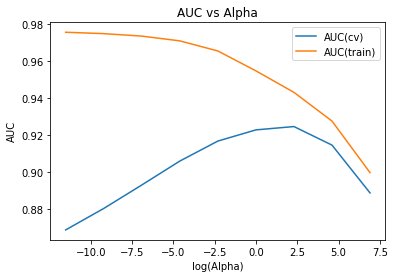

Best Alpha value =  10.0
Best Auc value =  0.9246460907029478


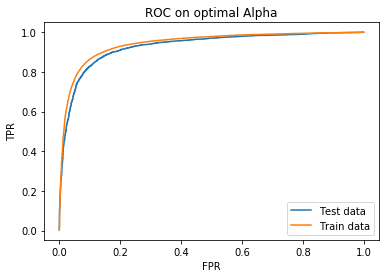

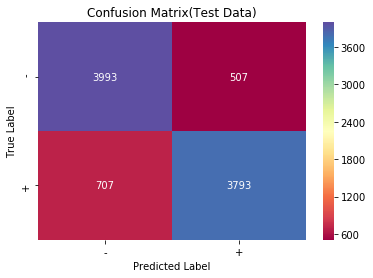

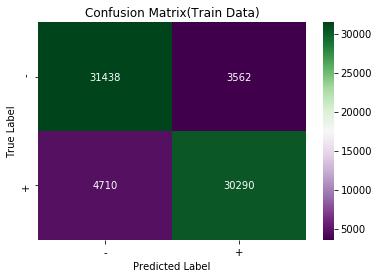

In [79]:
Alpha1,Auc1,predic_test1,predic_train1,LR1=BestAlpha(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [137]:
print('Classification Report on Test Data')
print('='*36)
print(classification_report(Y_test, predic_test1)+'\n')

print('Classification Report on Train Data')
print('='*36)

print(classification_report(Y_tr, predic_train1))

Classification Report on Test Data
             precision    recall  f1-score   support

          0       0.85      0.89      0.87      4500
          1       0.88      0.84      0.86      4500

avg / total       0.87      0.87      0.87      9000


Classification Report on Train Data
             precision    recall  f1-score   support

          0       0.87      0.90      0.88     35000
          1       0.89      0.87      0.88     35000

avg / total       0.88      0.88      0.88     70000



### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [138]:
Sorted_P = LR1.feature_log_prob_[1, :].argsort()
Sorted_P=Sorted_P[::-1] #Reversing indices(Because argsort sorts in ascending order)
print(np.take(count_vect.get_feature_names(), Sorted_P[:10]))

['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor' 'tea']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [139]:
Sorted_N = LR1.feature_log_prob_[0, :].argsort()
Sorted_N=Sorted_N[::-1] #Reversing indices(Because argsort sorts in ascending order)
print(np.take(count_vect.get_feature_names(), Sorted_N[:10]))

['not' 'like' 'product' 'would' 'taste' 'one' 'good' 'coffee' 'flavor'
 'get']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [140]:
#converting Reviews to tf_idf_vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)

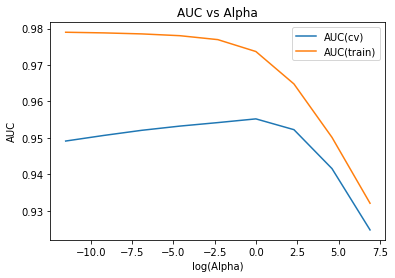

Best Alpha value =  1.0
Best Auc value =  0.9552276009070294


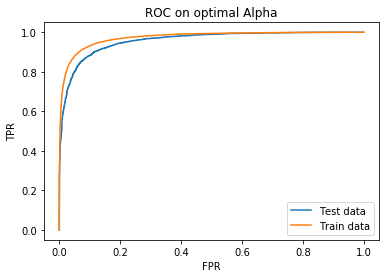

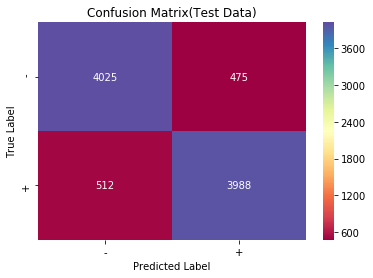

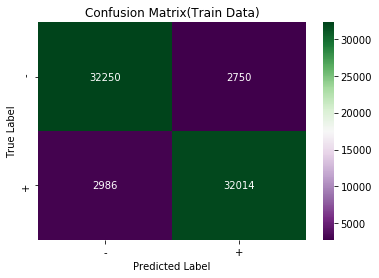

In [141]:
Alpha2,Auc2,predic_test2,predic_train2,LR2=BestAlpha(final_X_tr, Y_tr,final_X_test,Y_test,final_X_cv,Y_cv)

In [142]:
#Classification Reports
print('Classification Report on Test Data')
print('='*36)
print(classification_report(Y_test, predic_test2)+'\n')
print('Classification Report on Train Data')
print('='*36)
print(classification_report(Y_tr, predic_train2))

Classification Report on Test Data
             precision    recall  f1-score   support

          0       0.89      0.89      0.89      4500
          1       0.89      0.89      0.89      4500

avg / total       0.89      0.89      0.89      9000


Classification Report on Train Data
             precision    recall  f1-score   support

          0       0.92      0.92      0.92     35000
          1       0.92      0.91      0.92     35000

avg / total       0.92      0.92      0.92     70000



### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [144]:
Sorted_P = LR2.feature_log_prob_[1, :].argsort()
Sorted_P=Sorted_P[::-1] #Reversing indices(Because argsort sorts in ascending order)
print(np.take(count_vect.get_feature_names(), Sorted_P[:10]))

['heatblends' 'drinkanother' 'distracts' 'frowns' 'flaking' 'organics'
 'bryants' 'kiva' 'customerswhen' 'illustrated']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [145]:
Sorted_N = LR2.feature_log_prob_[0, :].argsort()
Sorted_N=Sorted_N[::-1] #Reversing indices(Because argsort sorts in ascending order)
print(np.take(count_vect.get_feature_names(), Sorted_N[:10]))

['heatblends' 'flaking' 'kiva' 'oilsize' 'punkin' 'bryants' 'illustrated'
 'customerswhen' 'distracts' 'organics']


# [6] Conclusions

In [146]:
from prettytable import PrettyTable    
Table = PrettyTable()
Table.field_names = ["Vector Type", "Hyper Parameter(Alpha)", "AUC"]
Table.add_row(["BOW",Alpha1,Auc1])
Table.add_row(["TFIDF",Alpha2,Auc2])
print(Table)

+-------------+------------------------+--------------------+
| Vector Type | Hyper Parameter(Alpha) |        AUC         |
+-------------+------------------------+--------------------+
|     BOW     |          10.0          | 0.9246479410430839 |
|    TFIDF    |          1.0           | 0.9552276009070294 |
+-------------+------------------------+--------------------+
